In [ ]:
only train

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [3]:
# Define dataset path
dataset_path = r"C:\Users\Welcome\2750"

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Load dataset using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0/255.0,   # Normalize pixel values
    validation_split=0.2, # 80-20 split for training and validation
    horizontal_flip=True, 
    rotation_range=30
)

# Training data
train_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get class names
class_names = list(train_dataset.class_indices.keys())
print("Classes:", class_names)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Images shape: (64, 224, 224, 3)
Labels shape: (64, 10)
Image 0 min value: 33, max value: 180
Image 1 min value: 60, max value: 255
Image 2 min value: 26, max value: 83
Image 3 min value: 76, max value: 255
Image 4 min value: 28, max value: 85
Image 5 min value: 68, max value: 255
Image 6 min value: 42, max value: 255
Image 7 min value: 32, max value: 235
Image 8 min value: 40, max value: 163


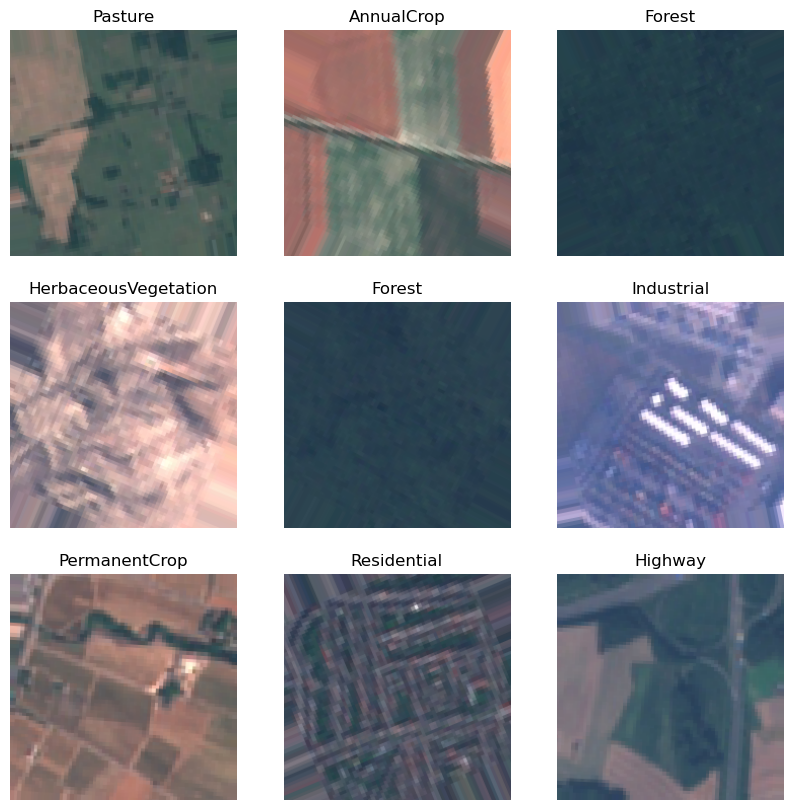

In [5]:
def visualize_images(dataset, class_indices, num_images=9):
    """
    Visualize a batch of images from the dataset.

    Parameters:
    - dataset: The dataset to visualize images from.
    - class_indices: Dictionary mapping class names to their corresponding indices.
    - num_images: Number of images to display (default: 9).
    """
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)  # Get the next batch of images and labels
    
    # Debugging: Print the shape of the images and labels
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        
        # Scale back to [0, 255] and convert to uint8
        img = images[i] * 255  # Scale back to [0, 255]
        img = img.astype("uint8")  # Convert to uint8
        
        # Debugging: Print min and max pixel values
        print(f"Image {i} min value: {img.min()}, max value: {img.max()}")
        
        plt.imshow(img)  # Display the image
        plt.title(list(class_indices.keys())[np.argmax(labels[i])])  # Get the class name from the label
        plt.axis("off")
    
    plt.show()

# Visualize training images
visualize_images(train_dataset, train_dataset.class_indices)

In [7]:
# Load EfficientNetB0 with pretrained weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)  # Regularization
output_layer = Dense(len(class_names), activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
EPOCHS = 20  

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


C:\Users\Welcome\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - accuracy: 0.1047 - loss: 2.3097 - val_accuracy: 0.1111 - val_loss: 2.2963
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.1188 - loss: 2.2973 - val_accuracy: 0.2146 - val_loss: 2.2959
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.1088 - loss: 2.2973 - val_accuracy: 0.1111 - val_loss: 2.2957
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.1083 - loss: 2.2977 - val_accuracy: 0.1111 - val_loss: 2.2953
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.1104 - loss: 2.2969 - val_accuracy: 0.1115 - val_loss: 2.2952
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.1162 - loss: 2.2968 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - accuracy: 0.1110 - loss: 2.2953 - val_accuracy: 0.1111 - val_loss: 2.2956
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.1089 - loss: 2.2960 - val_accu

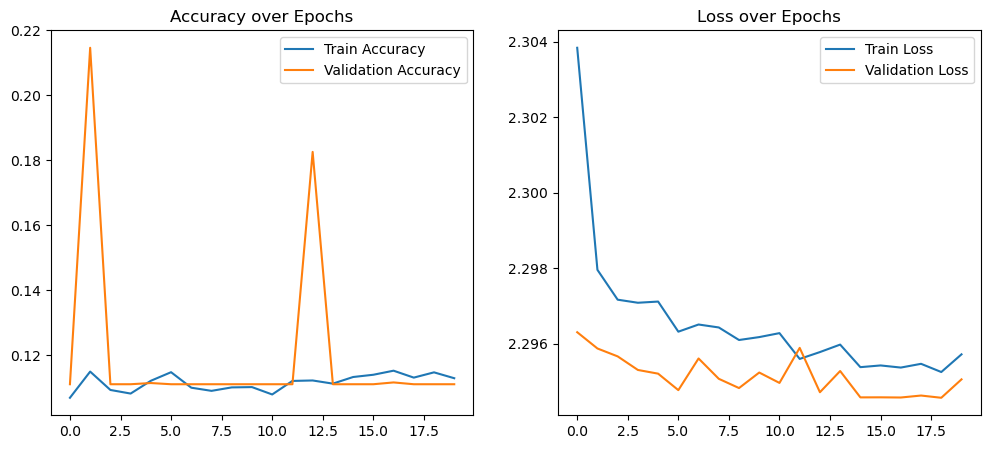

In [11]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 885ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

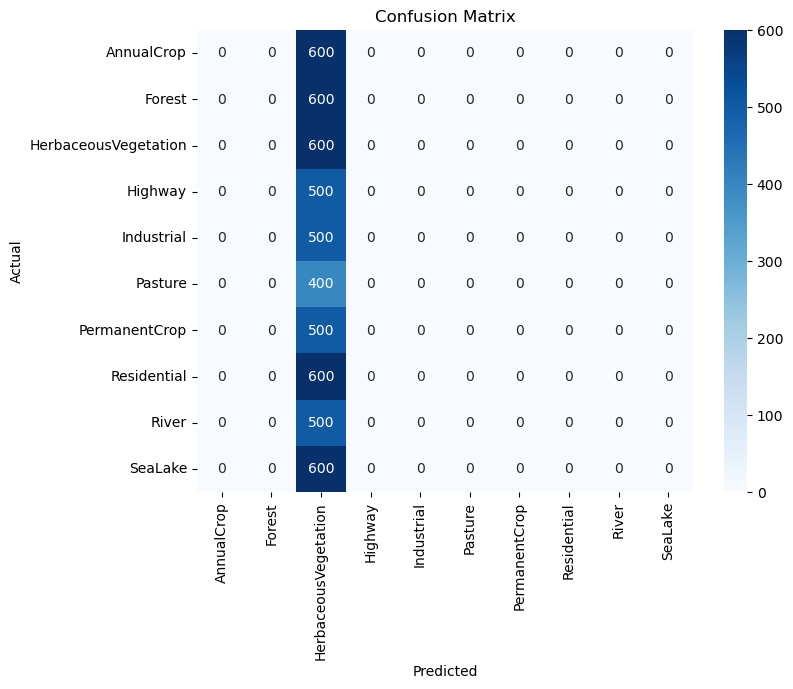

                      precision    recall  f1-score   support

          AnnualCrop       0.00      0.00      0.00       600
              Forest       0.00      0.00      0.00       600
HerbaceousVegetation       0.11      1.00      0.20       600
             Highway       0.00      0.00      0.00       500
          Industrial       0.00      0.00      0.00       500
             Pasture       0.00      0.00      0.00       400
       PermanentCrop       0.00      0.00      0.00       500
         Residential       0.00      0.00      0.00       600
               River       0.00      0.00      0.00       500
             SeaLake       0.00      0.00      0.00       600

            accuracy                           0.11      5400
           macro avg       0.01      0.10      0.02      5400
        weighted avg       0.01      0.11      0.02      5400



C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Get true labels and predictions
y_true = []
y_pred = []

for i in range(len(val_dataset)):
    x_batch, y_batch = val_dataset[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [17]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')